In [35]:
import os
import mne
import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from threading import Thread
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
# Use CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda()

Now using CUDA device 0
Enabling CUDA with 23.38 GB available memory


In [3]:
autodfname = 'auto_path_table.json'
autodf = pd.read_json(autodfname)
autodf.index

Index(['EEG_S01', 'EEG_S02', 'EEG_S03', 'EEG_S04', 'EEG_S05', 'EEG_S06',
       'EEG_S07', 'EEG_S08', 'EEG_S09', 'EEG_S10', 'MEG_S01', 'MEG_S02',
       'MEG_S03', 'MEG_S04', 'MEG_S05', 'MEG_S06', 'MEG_S07', 'MEG_S08',
       'MEG_S09', 'MEG_S10'],
      dtype='object')

In [4]:
DATA_DIR = 'processed_data'

def is_fif_file(path):
    """Whether [path] is legal propressed .fif file"""
    assert(isinstance(path, str))
    return path.endswith('_ica-raw.fif')

def get_MEG_events(raw, stim_channel='UPPT001'):
    """Get events from MEG data."""
    return mne.find_events(raw, stim_channel=stim_channel)

def get_EEG_events(raw):
    """Get events from EEG data."""
    return mne.events_from_annotations(raw)[0]

def make_profiles():
    """Make profiles"""
    profiles = pd.DataFrame()

    # Profiles for EEG
    profiles = profiles.append(pd.Series(dict(
        picks='eeg',
        decim=10,
        get_events=get_EEG_events
    ), name='EEG', dtype=object))

    # Profiles for MEG
    profiles = profiles.append(pd.Series(dict(
        picks='mag',
        decim=12,
        get_events=get_MEG_events
    ), name='MEG', dtype=object))

    # Global profiles
    profiles['n_jobs'] = 'cuda'  # N_JOBS
    profiles['tmin'] = TMIN
    profiles['tmax'] = TMAX
    
    return profiles


In [5]:
N_JOBS = 48
TMIN, TMAX = -0.2, 1.2

BANDS = pd.DataFrame(dict(
    Delta=(1, 4),
    Theta=(4, 7),
    Alpha=(8, 12),
    Beta=(13, 25),
    Gamma=(30, 45),
    U07=(0.1, 7),
    U30=(0.1, 30)))
BANDS.rename({0:'l_freq', 1:'h_freq'}, inplace=True)
BANDS

,Delta,Theta,Alpha,Beta,Gamma,U07,U30
l_freq,1,4,8,13,30,0.1,0.1
h_freq,4,7,12,25,45,7.0,30.0


In [6]:
PROFILES = make_profiles()
PROFILES

,decim,get_events,picks,n_jobs,tmin,tmax
EEG,10.0,<function get_EEG_events at 0x7f1ea5ff00e0>,eeg,cuda,-0.2,1.2
MEG,12.0,<function get_MEG_events at 0x7f1eb38de8c0>,mag,cuda,-0.2,1.2


In [7]:
def get_raw(series, profiles=PROFILES):
    """Get raw and profile"""
    assert(hasattr(series, 'fif_paths'))
    assert(hasattr(series, 'mode'))
    raw = mne.concatenate_raws([mne.io.read_raw_fif(e) for e in series['fif_paths']])
    profile = profiles.loc[series['mode']]
    return raw, profile
    
def relabel(events, sfreq):
    """Re-label 2 -> 4 when 2 is near to 1"""
    j = 0
    for a in events[events[:, -1]==1]:
        while True:
            if events[j, 0] > a[0] + sfreq:
                break
            if all([events[j, -1] == 2,
                    abs(events[j, 0] - a[0]) < sfreq]):
                events[j, -1] = 4
            j += 1
    return events
    
def get_epochs(raw, profile, band, bands=BANDS):
    """Get epochs"""
    # Get parameters
    band = 'U07'
    l_freq, h_freq = bands[band]
    picks = profile.picks
    tmin = profile.tmin
    tmax = profile.tmax
    decim = profile.decim
    n_jobs = profile.n_jobs
    
    events = profile.get_events(raw)
    sfreq = raw.info['sfreq']
    events = relabel(events, sfreq)
    
    # Copy and filter
    raw_copy = raw.copy()
    raw_copy.load_data()
    raw_copy.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)
    
    # Get epochs
    epochs = mne.Epochs(raw_copy, events=events, picks=picks, tmin=tmin, tmax=tmax, decim=decim)
    epochs.drop_bad()
    return epochs

raw_df = pd.DataFrame(columns=['mode', 'data_dir', 'fif_paths'])
for exper in autodf.index:
    data_dir = os.path.join(DATA_DIR, exper)
    fif_paths = sorted([os.path.join(data_dir, e) for e in os.listdir(data_dir) if is_fif_file(e)])
    
    raw_df = raw_df.append(pd.Series(dict(
        mode=exper[:3],
        data_dir=data_dir,
        fif_paths=fif_paths
    ), name=exper))
    
raw_df

,mode,data_dir,fif_paths
EEG_S01,EEG,processed_data/EEG_S01,"[processed_data/EEG_S01/block_02_ica-raw.fif, ..."
EEG_S02,EEG,processed_data/EEG_S02,"[processed_data/EEG_S02/block_02_ica-raw.fif, ..."
EEG_S03,EEG,processed_data/EEG_S03,"[processed_data/EEG_S03/block_02_ica-raw.fif, ..."
EEG_S04,EEG,processed_data/EEG_S04,"[processed_data/EEG_S04/block_02_ica-raw.fif, ..."
EEG_S05,EEG,processed_data/EEG_S05,"[processed_data/EEG_S05/block_02_ica-raw.fif, ..."
EEG_S06,EEG,processed_data/EEG_S06,"[processed_data/EEG_S06/block_02_ica-raw.fif, ..."
EEG_S07,EEG,processed_data/EEG_S07,"[processed_data/EEG_S07/block_02_ica-raw.fif, ..."
EEG_S08,EEG,processed_data/EEG_S08,"[processed_data/EEG_S08/block_02_ica-raw.fif, ..."
EEG_S09,EEG,processed_data/EEG_S09,"[processed_data/EEG_S09/block_02_ica-raw.fif, ..."
EEG_S10,EEG,processed_data/EEG_S10,"[processed_data/EEG_S10/block_02_ica-raw.fif, ..."


In [26]:
DATA_SHOP = dict()

In [38]:
epochs.events

array([[   9540,       0,       2],
       [   9633,       0,       2],
       [   9729,       0,       2],
       ...,
       [2328695,       0,       4],
       [2328790,       0,       4],
       [2328884,       0,       2]])

In [28]:
for name in ['EEG_S04', 'MEG_S04']:
    raw, profile = get_raw(raw_df.loc[name])
    epochs = get_epochs(raw, profile, band='U07')
    DATA_SHOP[name] = dict(
        raw=raw,
        profile=profile,
        epochs=epochs
    )
pprint(DATA_SHOP)

Opening raw data file processed_data/EEG_S04/block_02_ica-raw.fif...
Isotrak not found
    Range : 0 ... 235839 =      0.000 ...   235.839 secs
Ready.
Opening raw data file processed_data/EEG_S04/block_03_ica-raw.fif...
Isotrak not found
    Range : 0 ... 225759 =      0.000 ...   225.759 secs
Ready.
Opening raw data file processed_data/EEG_S04/block_04_ica-raw.fif...
Isotrak not found
    Range : 0 ... 252839 =      0.000 ...   252.839 secs
Ready.
Opening raw data file processed_data/EEG_S04/block_05_ica-raw.fif...
Isotrak not found
    Range : 0 ... 228759 =      0.000 ...   228.759 secs
Ready.
Opening raw data file processed_data/EEG_S04/block_06_ica-raw.fif...
Isotrak not found
    Range : 0 ... 215399 =      0.000 ...   215.399 secs
Ready.
Opening raw data file processed_data/EEG_S04/block_07_ica-raw.fif...
Isotrak not found
    Range : 0 ... 231919 =      0.000 ...   231.919 secs
Ready.
Opening raw data file processed_data/EEG_S04/block_08_ica-raw.fif...
Isotrak not found
    Ran

EEG_S04-1


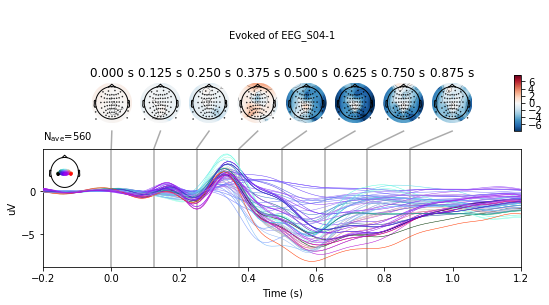

EEG_S04-2


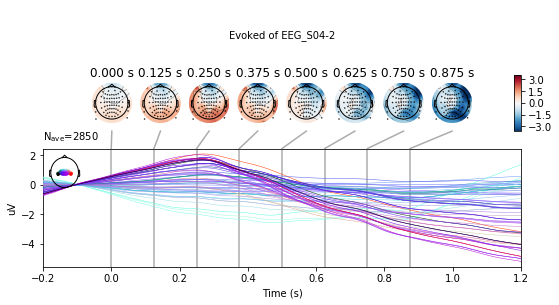

EEG_S04-3


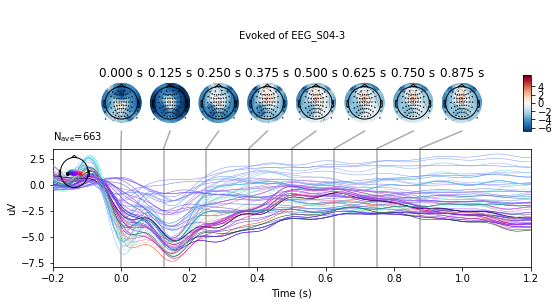

MEG_S04-1


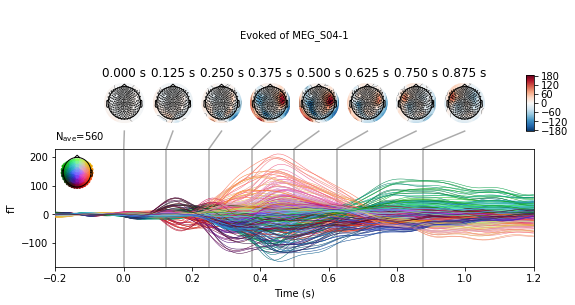

MEG_S04-2


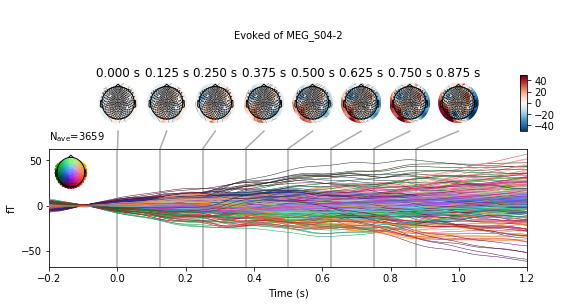

MEG_S04-3


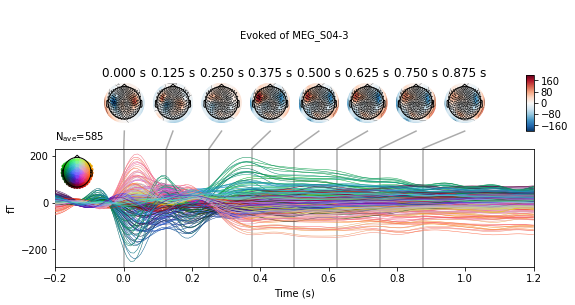

Done.


In [30]:
evoked = dict()
for name in DATA_SHOP:
    epochs = DATA_SHOP[name]['epochs']
    for idx in ['1', '2', '3']:
        title = f'{name}-{idx}'
        print(title)
        evoked[title] = epochs[idx].average()
        evoked[title].plot_joint(times=np.linspace(0, 1.0, 8, endpoint=False), title=f'Evoked of {title}')
print('Done.')

Loading data for 560 events and 1401 original time points ...


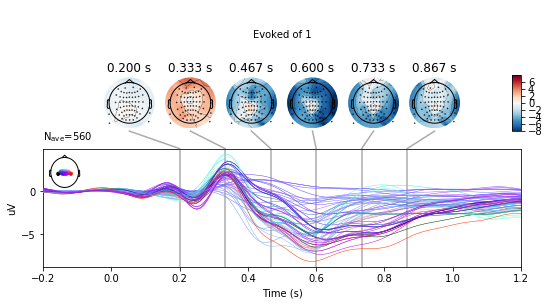

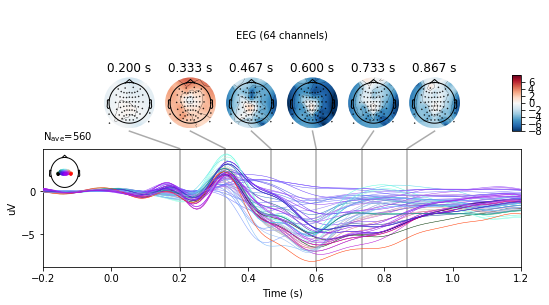

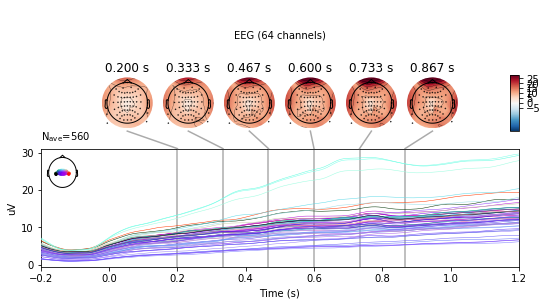

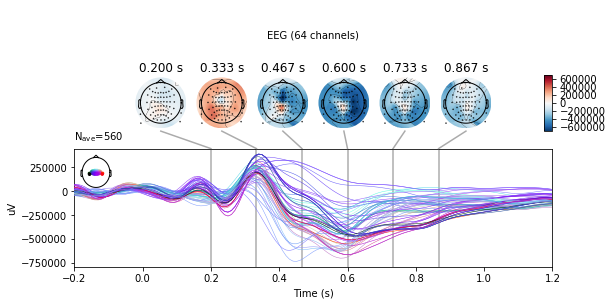

Done.


In [23]:
e = epochs['1']
d = e.get_data()

evoked = e.average()
evoked.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False), title='Evoked of 1')

MEAN = d.mean(axis=0)
STD = d.std(axis=0)
MIX = MEAN / STD

evoked_mean = evoked.copy()
evoked_mean.data = MEAN
evoked_mean.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

evoked_std = evoked.copy()
evoked_std.data = STD
evoked_std.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

evoked_mix = evoked.copy()
evoked_mix.data = MIX
evoked_mix.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

print('Done.')

((64, 141), (64, 141))

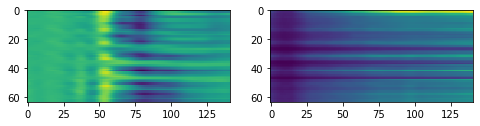

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(MEAN)
axes[1].imshow(STD)
MEAN.shape, STD.shape

Loading data for 2850 events and 1401 original time points ...


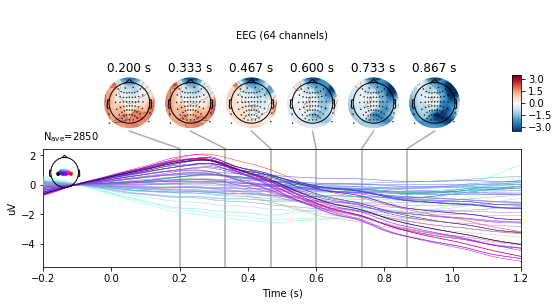

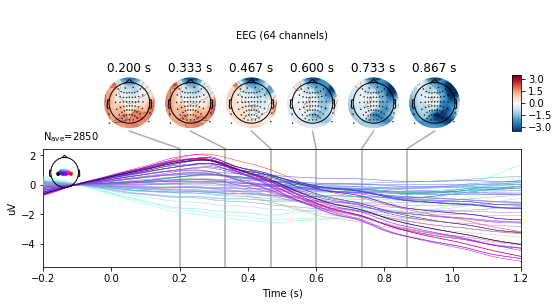

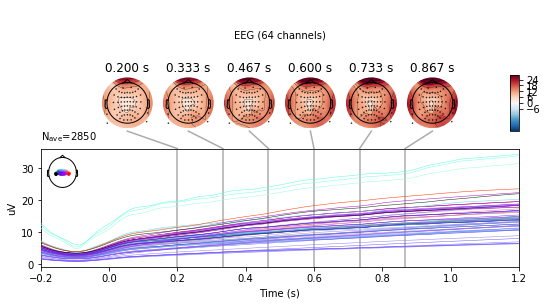

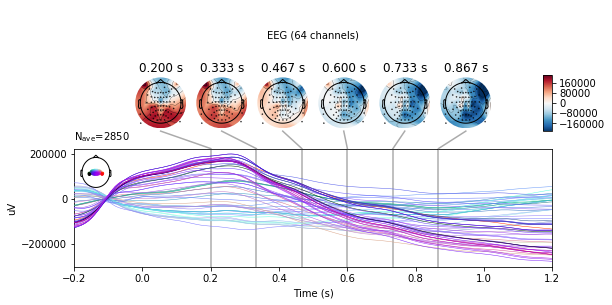

Done.


In [22]:
e = epochs['2']
d = e.get_data()

evoked = e.average()
evoked.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

MEAN = d.mean(axis=0)
STD = d.std(axis=0)
MIX = MEAN / STD

evoked_mean = evoked.copy()
evoked_mean.data = MEAN
evoked_mean.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

evoked_std = evoked.copy()
evoked_std.data = STD
evoked_std.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

evoked_mix = evoked.copy()
evoked_mix.data = MIX
evoked_mix.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

print('Done.')

Loading data for 663 events and 1401 original time points ...


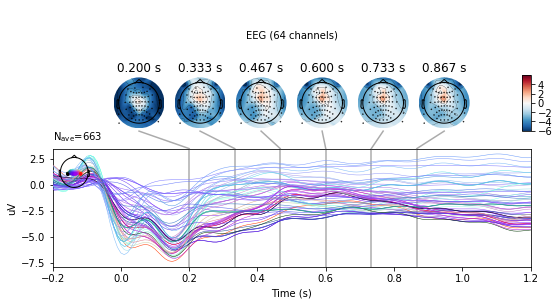

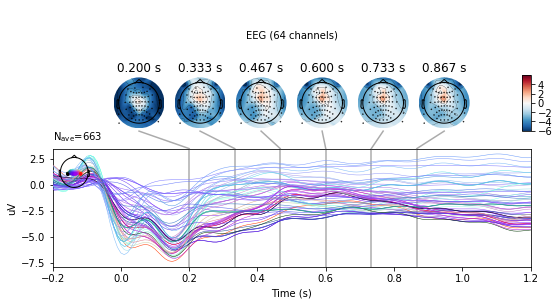

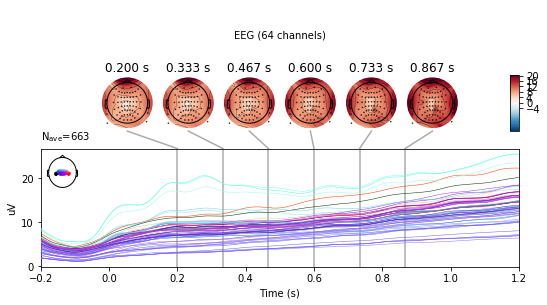

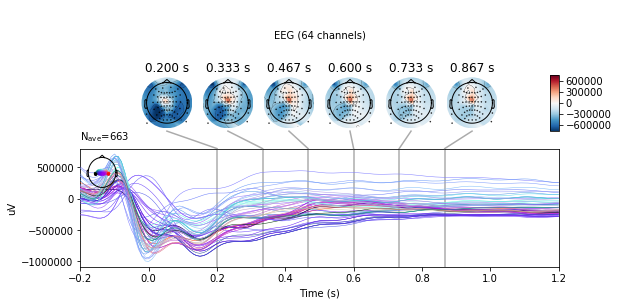

Done.


In [25]:
e = epochs['3']
d = e.get_data()

evoked = e.average()
evoked.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

MEAN = d.mean(axis=0)
STD = d.std(axis=0)
MIX = MEAN / STD

evoked_mean = evoked.copy()
evoked_mean.data = MEAN
evoked_mean.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

evoked_std = evoked.copy()
evoked_std.data = STD
evoked_std.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

evoked_mix = evoked.copy()
evoked_mix.data = MIX
evoked_mix.plot_joint(times=np.linspace(0.2, 1.0, 6, endpoint=False))

print('Done.')